# Importing the packages and data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma
import math
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize
from scipy.stats import ttest_ind
from scipy.optimize import Bounds

from prettytable import PrettyTable

In [4]:
from multiprocessing import Pool
from functools import partial

In [5]:
import sys
sys.path.append("../smote_cd/")
import smote_cd

In [18]:
import sys
sys.path.append("../../coral_mapping/")
import segments_regressor
import coral_map_tests

In [9]:
import dirichlet_regression

In [7]:
from scipy.optimize import fmin, newton, minimize

In [8]:
def f_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    M = np.identity(n) - rho*W
    mu = dirichlet_regression.compute_mu_spatial_opti(X, beta, M)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [9]:
def fprime_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    M = np.identity(n) - rho*W
    MinvX = np.linalg.solve(M,X)
    mu = dirichlet_regression.compute_mu_spatial_opti(X, beta, M, MinvX=MinvX)
    phi = np.exp(np.matmul(Z,gamma_var))

    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, MinvX, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, Y, Z, epsilon=epsilon)
    
    MinvW = np.linalg.solve(M,W)
    rho_derivative = dirichlet_regression.dirichlet_derivative_wrt_rho(mu, phi, beta, W, X, Y, Z, MinvX=MinvX, MinvW=MinvW, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad,[rho_derivative]]))

In [10]:
def f_no_spatial(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    #phi = np.exp(Z*gamma_var)
    return -1/n * dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [11]:
def fprime_no_spatial(x, X, Y, Z, epsilon=0):
    n = X.shape[0]
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    #phi = np.exp(Z*gamma_var)
    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, X, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, Y, Z, epsilon=epsilon)
    return(-1/n * np.concatenate([beta_grad.flatten(),gamma_grad]))

In [12]:
def f_no_spatial(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x.reshape((K,J))
    beta[:,0] = 0
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.ones(n)
    return -1/n * dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [13]:
def f_no_spatial_crossentropy(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x.reshape((K,J))
    beta[:,0] = 0
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.ones(n)
    print(mu)
    return 1/n * np.sum(Y*np.log(mu))

In [15]:
# sur ordi MQ:
scipy.__version__

'1.9.1'

In [77]:
# sur mon ordi perso:
scipy.__version__

'1.4.1'

# Loading Maupiti data

In [14]:
img_B02 = np.load('../maupiti/Satellite Images/sentinel_B2_new.npy')
img_B03 = np.load('../maupiti/Satellite Images/sentinel_B3_new.npy')
img_B04 = np.load('../maupiti/Satellite Images/sentinel_B4_new.npy')
img_B08 = np.load('../maupiti/Satellite Images/sentinel_B8_new.npy')

In [15]:
img_B02 = np.load('../maupiti/Satellite Images/sentinel_B2_20220828.npy')
img_B03 = np.load('../maupiti/Satellite Images/sentinel_B3_20220828.npy')
img_B04 = np.load('../maupiti/Satellite Images/sentinel_B4_20220828.npy')
img_B08 = np.load('../maupiti/Satellite Images/sentinel_B8_20220828.npy')

In [31]:
maupiti_zones = np.load('../../maupiti/Satellite Images/sentinel_rugo_new.npy')
#maupiti_zones = np.load('../maupiti/Satellite Images/sentinel_rugo_new_grouped_8.npy')

In [17]:
map_test=coral_map_tests.coral_map([img_B02,img_B03,img_B04,img_B08], map_img=maupiti_zones)

In [18]:
map_test.segmentation(method='fz',scale=0.9, min_size=40)
np.max(map_test.segments)

2322

In [19]:
boundaries = coral_map_tests.find_boundaries(map_test.segments)
adjacent_segments,_ = segments_regressor.find_adjacent_segments(map_test.segments, boundaries)

In [20]:
X_maupiti = segments_regressor.create_features(map_test.segments, map_test.blue_band, map_test.green_band, map_test.red_band, map_test.nir_band)
Y_maupiti = coral_map_tests.create_labels_dataset(map_test.segments,map_test.map_img)

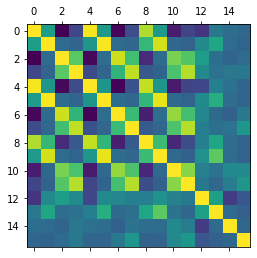

In [21]:
plt.matshow(X_maupiti.corr())
plt.show()

In [22]:
# Create correlation matrix
corr_matrix = X_maupiti.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.4)]

# Drop features 
X_maupiti_less_features = X_maupiti.drop(to_drop, axis=1)

In [23]:
X_maupiti_less_features.corr()

,mean_blue,var_blue,mean_nir,skew_nir,kurt_nir
mean_blue,1.000000,0.338209,-0.259352,0.052624,0.004406
var_blue,0.338209,1.000000,0.213142,0.030445,-0.005806
mean_nir,-0.259352,0.213142,1.000000,-0.222240,-0.080753
skew_nir,0.052624,0.030445,-0.222240,1.000000,0.009483
kurt_nir,0.004406,-0.005806,-0.080753,0.009483,1.000000


In [24]:
n_features = 5
#n_classes = 8
n_classes = 15
n_samples = X_maupiti.shape[0]

In [25]:
Y_star_maupiti = (Y_maupiti*(n_samples-1)+1/n_classes)/n_samples

In [26]:
Z_maupiti = np.ones((n_samples,n_features))

In [27]:
Z_maupiti = np.ones(n_samples).reshape(-1,1)
#Z_maupiti = np.ones((n_samples,2))
#Z_maupiti[:,1] = np.array(X_maupiti)[:,0]/np.max(np.array(X_maupiti)[:,0])

In [28]:
W_maupiti = np.zeros((n_samples,n_samples))
for i in range(n_samples):
    W_maupiti[i,adjacent_segments[i]]=1

W_maupiti = W_maupiti/W_maupiti.sum(axis=1)[:,None]

### With an intercept

In [ ]:
X_maupiti_1 = np.ones((n_samples,n_features+1))
X_maupiti_1[:,1] = X_maupiti_less_features['mean_blue']
X_maupiti_1[:,2] = X_maupiti_less_features['mean_nir']
X_maupiti_1[:,3] = X_maupiti_less_features['var_nir']
X_maupiti_1_bis = StandardScaler().fit(X_maupiti_1).transform(X_maupiti_1)
X_maupiti_1_bis[:,0] = np.ones(n_samples)

In [30]:
X_maupiti_1 = np.ones((n_samples,n_features+1))
#X_maupiti_1[:,1:] = X_maupiti.fillna(0)
X_maupiti_1[:,1:] = X_maupiti_less_features.fillna(0)

In [31]:
X_maupiti_1_bis = np.copy(X_maupiti_1)
X_maupiti_1_bis[:,1:] = StandardScaler().fit(X_maupiti_less_features.fillna(0)).transform(X_maupiti_less_features.fillna(0))

In [118]:
X_maupiti_1 = np.ones((n_samples,n_features))
X_maupiti_1 = X_maupiti_less_features.fillna(0)
X_maupiti_1_bis = np.copy(X_maupiti_1)
X_maupiti_1_bis = StandardScaler().fit(X_maupiti_less_features.fillna(0)).transform(X_maupiti_less_features.fillna(0))

In [314]:
X_maupiti_2 = np.ones((n_samples,n_features+1))
X_maupiti_2[:,1:n_features//2+1] = X_maupiti_1_bis[:,1:]
X_maupiti_2[:,n_features//2+1:] = X_maupiti_1_bis[:,1:]**2

In [83]:
X_maupiti_1_bis = np.copy(X_maupiti_1)
X_maupiti_1_bis[:,1:] = StandardScaler().fit(X_maupiti.fillna(0)).transform(X_maupiti.fillna(0))

ValueError: could not broadcast input array from shape (2323,16) into shape (2323,5)

In [32]:
beta_maupiti = np.ones((1+n_features)*n_classes+(1+n_features))[:(1+n_features)*n_classes].reshape(((1+n_features),n_classes))
#beta_maupiti = np.ones((n_features)*n_classes+(n_features))[:(n_features)*n_classes].reshape(((n_features),n_classes))
beta_maupiti[:,0] = 0

gamma_maupiti = np.zeros(Z_maupiti.shape[-1])
#gamma_maupiti = [0.]
rho_maupiti = [0.1]

params0_maupiti = np.concatenate([beta_maupiti.flatten(),gamma_maupiti,rho_maupiti])
params0_maupiti_ns = np.concatenate([beta_maupiti.flatten(),gamma_maupiti])

In [190]:
params0_maupiti_ns_bis = np.concatenate([beta_maupiti.flatten()])

In [160]:
min_bounds = -np.inf*np.ones(len(params0_maupiti)) 
max_bounds = np.inf*np.ones(len(params0_maupiti))
min_bounds[-1] = -1
max_bounds[-1] = 1
bounds = Bounds(min_bounds, max_bounds)

In [33]:
train_ind, test_ind = train_test_split(np.arange(len(X_maupiti_1_bis)),test_size=0.25)
#train_ind, test_ind = train_test_split(np.arange(len(X_maupiti_2)),test_size=0.25)

In [34]:
X_train, X_test = X_maupiti_1_bis[train_ind], X_maupiti_1_bis[test_ind]
Y_train, Y_test = Y_star_maupiti[train_ind], Y_star_maupiti[test_ind]
Z_train, Z_test = Z_maupiti[train_ind], Z_maupiti[test_ind]
W_train, W_test = W_maupiti[train_ind][:,train_ind], W_maupiti[test_ind][:,test_ind]

In [39]:
X_train, X_test = X_maupiti_2[train_ind], X_maupiti_2[test_ind]
Y_train, Y_test = Y_star_maupiti[train_ind], Y_star_maupiti[test_ind]
Z_train, Z_test = Z_maupiti[train_ind], Z_maupiti[test_ind]
W_train, W_test = W_maupiti[train_ind][:,train_ind], W_maupiti[test_ind][:,test_ind]

NameError: name 'X_maupiti_2' is not defined

In [257]:
Nfeval = 0
list_ll_iter = []

def callbackF(params):
    global Nfeval
    ll = f_no_spatial(params, X_train, Y_train, Z_train)
    Nfeval += 1
    list_ll_iter.append(ll)
    print(Nfeval, ll)

In [164]:
%%time
solution_maupiti_ns_bis=minimize(f_no_spatial, params0_maupiti_ns, args=(X_train, Y_train, Z_train), jac=fprime_no_spatial,
                                callback = callbackF)

1 -92.79751859760547
2 -92.92610006564753
3 -92.97382772431972
4 -93.0549538160221
5 -93.1938174166304
6 -93.42654979943285
7 -93.62009190486148
8 -93.76975560523987
9 -93.91626179619367
10 -94.12307560318797
11 -94.21641443201673
12 -94.26292803907626
13 -94.32151256317566
14 -94.34779129174638
15 -94.36755757030933
16 -94.3806262960339
17 -94.3853884061789
18 -94.38670040865264
19 -94.38772234237217
20 -94.38900875931495
21 -94.3907979930903
22 -94.39309063047077
23 -94.39469332212084
24 -94.39570973234976
25 -94.39684307270024
26 -94.3986003146938
27 -94.40134995296572
28 -94.40303804100584
29 -94.40496290039287
30 -94.40572038057202
31 -94.40587948906604
32 -94.40593142339247
33 -94.40599703800882
34 -94.40605282703893
35 -94.40609332039708
36 -94.40610921940352
37 -94.40611262948693
38 -94.40611466186849
39 -94.40611791567666
40 -94.40612278284893
41 -94.40612706863679
42 -94.40612879474071
43 -94.40612912420502
44 -94.40612914577862
45 -94.40612914793148
Wall time: 5.91 s


In [165]:
solution_maupiti_ns_bis.message

'Optimization terminated successfully.'

In [168]:
beta_maupiti_1_ns = solution_maupiti_ns_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
#beta_maupiti_1_ns = solution_maupiti_ns_bis.x[:(n_features)*n_classes].reshape((n_features,n_classes))

mu_maupiti_1_ns = dirichlet_regression.compute_mu_2(X_maupiti_1_bis, beta_maupiti_1_ns)
#mu_maupiti_1_ns = dirichlet_regression.compute_mu_2(X_maupiti_2, beta_maupiti_1_ns)

gamma_var_maupiti_1_ns = solution_maupiti_ns_bis.x[(n_features+1)*n_classes:]
#gamma_var_maupiti_1_ns = solution_maupiti_ns_bis.x[(n_features)*n_classes:]
phi_maupiti_1_ns = np.exp(np.matmul(Z_maupiti,gamma_var_maupiti_1_ns))

In [169]:
beta_maupiti_1_ns

array([[ 0.        , -0.76741229, -0.78200701, -0.71423054, -0.68788196,
        -0.69900584, -0.68095451, -0.74267136, -0.75941807, -0.77030123,
        -0.55727817, -0.54170517, -0.69041235, -0.69892749, -0.60047467],
       [ 0.        ,  0.38820992,  0.38796315,  0.39014031,  0.35638093,
         0.37680047,  0.40168902,  0.3656596 ,  0.3764631 ,  0.37538522,
         0.73868836,  0.32325038,  0.38877642,  0.48053756,  0.5523251 ],
       [ 0.        , -0.06775424, -0.06509258,  0.05800241, -0.02706829,
        -0.06250593,  0.14402051, -0.0597032 , -0.0619082 , -0.05640976,
        -0.2971577 , -0.05895434, -0.06394515, -0.12030769, -0.1610754 ],
       [ 0.        , -0.52031993, -0.5256744 , -0.52647777, -0.55712895,
        -0.59250797, -0.52512594, -0.54036575, -0.54473359, -0.53891669,
        -0.52293426, -0.70568174, -0.57296866, -0.51845711, -0.56940762],
       [ 0.        , -0.12644595, -0.13940427, -0.11463728, -0.07685436,
        -0.18794819, -0.098007  , -0.13732477, 

In [129]:
# With Z dimension 1, 5 features without intercept (correlated less than 0.4)
print('Scores between Y and mu')
print('R2 :',r2_score(Y_star_maupiti,mu_maupiti_1_ns))
print('RMSE :',mean_squared_error(Y_star_maupiti,mu_maupiti_1_ns,squared=False))
print('AIC :',2*len(solution_maupiti_ns_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_1_ns,phi_maupiti_1_ns,Y_star_maupiti))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],mu_maupiti_1_ns[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(mu_maupiti_1_ns[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-mu_maupiti_1_ns[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and mu
R2 : -0.4918879075558654
RMSE : 0.1896495748539642
AIC : -437655.02256561967
Mean cosine similarity : 0.43040176371738575
Mean euclidian distance : 0.8387259253296562


In [50]:
# With Z dimension 1, 5 features (correlated less than 0.4)
print('Scores between Y and mu')
print('R2 :',r2_score(Y_star_maupiti,mu_maupiti_1_ns))
print('RMSE :',mean_squared_error(Y_star_maupiti,mu_maupiti_1_ns,squared=False))
print('AIC :',2*len(solution_maupiti_ns_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_1_ns,phi_maupiti_1_ns,Y_star_maupiti))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],mu_maupiti_1_ns[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(mu_maupiti_1_ns[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-mu_maupiti_1_ns[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and mu
R2 : -0.3389199281153498
RMSE : 0.18436390434342306
AIC : -438751.617646317
Mean cosine similarity : 0.4900252725298407
Mean euclidian distance : 0.8087227129210925


In [329]:
# With Z dimension 1, 8 features (correlated less than 0.6)
print('Scores between Y and mu')
print('R2 :',r2_score(Y_star_maupiti,mu_maupiti_1_ns))
print('RMSE :',mean_squared_error(Y_star_maupiti,mu_maupiti_1_ns,squared=False))
print('AIC :',2*len(solution_maupiti_ns_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_1_ns,phi_maupiti_1_ns,Y_star_maupiti))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],mu_maupiti_1_ns[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(mu_maupiti_1_ns[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-mu_maupiti_1_ns[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and mu
R2 : -0.339269999036682
RMSE : 0.1841920630458125
AIC : -438745.01207334065
Mean cosine similarity : 0.495273772069289
Mean euclidian distance : 0.8067349150895988


In [218]:
print('Mean cosine similarity :',np.mean([np.dot(mu_maupiti_1_ns[i],Y_pred[i])/(np.linalg.norm(mu_maupiti_1_ns[i])*np.linalg.norm(Y_pred[i])) for i in range(len(mu_maupiti_1_ns))]))

Mean cosine similarity : 0.5614656954428393


In [115]:
# With Z dimension 1, all features
print('Scores between Y and mu')
print('R2 :',r2_score(Y_star_maupiti,mu_maupiti_1_ns))
print('RMSE :',mean_squared_error(Y_star_maupiti,mu_maupiti_1_ns,squared=False))
print('AIC :',2*len(solution_maupiti_ns_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_1_ns,phi_maupiti_1_ns,Y_star_maupiti))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],mu_maupiti_1_ns[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(mu_maupiti_1_ns[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-mu_maupiti_1_ns[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and mu
R2 : -0.2870672085395858
RMSE : 0.18049473497200702
AIC : -439031.70742983656
Mean cosine similarity : 0.5435770453043292
Mean euclidian distance : 0.7892166995438228


In [80]:
# With Z same dimension as X, all features
print('Scores between Y and mu')
print('R2 :',r2_score(Y_star_maupiti,mu_maupiti_1_ns))
print('RMSE :',mean_squared_error(Y_star_maupiti,mu_maupiti_1_ns,squared=False))
print('AIC :',2*len(solution_maupiti_ns_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_1_ns,phi_maupiti_1_ns,Y_star_maupiti))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],mu_maupiti_1_ns[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(mu_maupiti_1_ns[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-mu_maupiti_1_ns[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and mu
R2 : -0.28993212158297366
RMSE : 0.1804063084769662
AIC : -438945.7539372707
Mean cosine similarity : 0.5466693370163446
Mean euclidian distance : 0.7882726248350086


In [81]:
mu_maupiti_1_ns_test = dirichlet_regression.compute_mu_2(X_test, beta_maupiti_1_ns)

In [82]:
print('Scores between Y and mu')
print('R2 :',r2_score(Y_test,mu_maupiti_1_ns_test))
print('RMSE :',mean_squared_error(Y_test,mu_maupiti_1_ns_test,squared=False))
print('Mean cosine similarity :',np.mean([np.dot(Y_test[i],mu_maupiti_1_ns_test[i])/(np.linalg.norm(Y_test[i])*np.linalg.norm(mu_maupiti_1_ns_test[i])) for i in range(len(Y_test))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_test[i]-mu_maupiti_1_ns_test[i]) for i in range(len(Y_test))]))

Scores between Y and mu
R2 : -1.510157566538332e+34
RMSE : 0.1834407086792386
Mean cosine similarity : 0.5385404387102708
Mean euclidian distance : 0.7958448360764078


In [83]:
argmax_segments_ns = np.argmax(mu_maupiti_1_ns,axis=1)

In [86]:
np.unique(argmax_segments_ns)

array([ 0,  4,  5,  6, 10, 11, 14], dtype=int64)

In [84]:
map_dirichlet_ns = np.zeros(np.shape(map_test.segments))
for i, s in enumerate(argmax_segments_ns):
    map_dirichlet_ns[map_test.segments==i] = s

In [87]:
argmax_segments_true = np.argmax(Y_star_maupiti,axis=1)
map_ideal = np.zeros(np.shape(map_test.segments))
for i, s in enumerate(argmax_segments_true):
    map_ideal[map_test.segments==i] = s

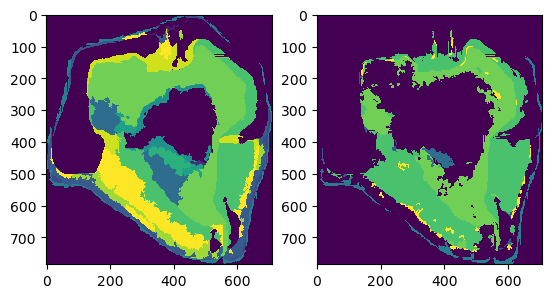

In [92]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(map_ideal, interpolation='None')
ax[1].imshow(map_dirichlet_ns, interpolation='None')
plt.show()

In [ ]:
%%time
solution_maupiti_s_bis=minimize(f_spatial, params0_maupiti, args=(X_train, Y_train, Z_train, W_train), jac=fprime_spatial, bounds=bounds)

In [ ]:
beta_maupiti_1_s = solution_maupiti_s_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))

mu_maupiti_1_s = dirichlet_regression.compute_mu_2(X_maupiti_1_bis, beta_maupiti_1_s)

gamma_var_maupiti_1_s = solution_maupiti_s_bis.x[(n_features+1)*n_classes:]
phi_maupiti_1_s = np.exp(np.matmul(Z_maupiti,gamma_var_maupiti_1_s))

# Trying with RF

In [97]:
from sklearn.ensemble import RandomForestRegressor

In [301]:
rf = RandomForestRegressor(random_state=0)

In [302]:
rf.fit(X_train, Y_train)

RandomForestRegressor(random_state=0)

In [303]:
Y_pred = rf.predict(X_maupiti_1_bis)

In [304]:
# With Random Forest
print('Scores between Y and Y hat (RF)')
print('R2 :',r2_score(Y_star_maupiti,Y_pred))
print('RMSE :',mean_squared_error(Y_star_maupiti,Y_pred,squared=False))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],Y_pred[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(Y_pred[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-Y_pred[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and Y hat (RF)
R2 : 0.7278507002099233
RMSE : 0.07954822606963746
Mean cosine similarity : 0.9239065133722446
Mean euclidian distance : 0.2247948238942452


In [305]:
Y_pred = rf.predict(X_test)
# With Random Forest
print('Scores between Ytest and Y hat (RF), ONLY test set')
print('R2 :',r2_score(Y_test,Y_pred))
print('RMSE :',mean_squared_error(Y_test,Y_pred,squared=False))
print('Mean cosine similarity :',np.mean([np.dot(Y_test[i],Y_pred[i])/(np.linalg.norm(Y_test[i])*np.linalg.norm(Y_pred[i])) for i in range(len(Y_test))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_test[i]-Y_pred[i]) for i in range(len(Y_test))]))

Scores between Ytest and Y hat (RF), ONLY test set
R2 : 0.31211406855555146
RMSE : 0.13360517876683628
Mean cosine similarity : 0.7579189413912332
Mean euclidian distance : 0.4210768680778783


In [276]:
rf.feature_importances_

array([0.        , 0.40878961, 0.08533413, 0.05539831, 0.04675425,
       0.19338719, 0.11662273, 0.05139259, 0.04232119])

# Logistic regression

In [51]:
from sklearn.linear_model import LogisticRegression

In [98]:
clf = LogisticRegression(random_state=0, max_iter=2000, penalty='none', fit_intercept=False, multi_class='multinomial')

In [99]:
clf.fit(X_train, np.argmax(Y_train,axis=1))

LogisticRegression(fit_intercept=False, max_iter=2000,
                   multi_class='multinomial', penalty='none', random_state=0)

In [100]:
Y_pred = clf.predict_proba(X_maupiti_1_bis)

In [101]:
# With logistic
print('Scores between Y and Y hat (logistic regression)')
print('R2 :',r2_score(Y_star_maupiti,Y_pred))
print('RMSE :',mean_squared_error(Y_star_maupiti,Y_pred,squared=False))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],Y_pred[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(Y_pred[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-Y_pred[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and Y hat (logistic regression)
R2 : 0.2581158614237359
RMSE : 0.1435735329284507
Mean cosine similarity : 0.7062453176197242
Mean euclidian distance : 0.5278351265335562


In [103]:
beta_maupiti_ns_softmax = clf.coef_.transpose()

mu_maupiti_ns_softmax = dirichlet_regression.compute_mu_2(X_maupiti_1_bis, beta_maupiti_ns_softmax)
#mu_maupiti_1_ns = dirichlet_regression.compute_mu_2(X_maupiti_2, beta_maupiti_1_ns)

gamma_var_maupiti_1_ns = solution_maupiti_ns_bis.x[(n_features+1)*n_classes:]
phi_maupiti_1_ns = np.exp(np.matmul(Z_maupiti,gamma_var_maupiti_1_ns))

In [109]:
clf.coef_

array([[  8.88552048,  -4.73542852,   1.37875299,  13.68889903,
         -0.67953608,   3.05248217],
       [  0.87229231,  -3.82225873,   0.42168565,  13.07911274,
         -5.17786926,  -8.91246311],
       [  4.80457246,  -0.34758826,  -0.12576285,   9.33718328,
          0.58559504,   0.36802446],
       [  6.92115583,  -1.44172336,   1.18499749,  12.13652983,
          0.89059669,   0.68468685],
       [  7.5887507 ,   0.81471506,   0.69650982,   8.87776351,
          1.06079297,   0.49849383],
       [ -7.14119044,   1.00725154,   2.10699617, -17.45665101,
         -0.95416787,   2.6272558 ],
       [  7.51777387,   0.51440799,   1.30213472,  10.6662549 ,
          0.11827976,   1.8661872 ],
       [  7.96836085,  -1.38097282,  -1.56253485,  12.32170865,
          0.39934467,   1.35559387],
       [  2.89108742,   0.52210695,  -2.91253582,   6.27975079,
          3.17648722, -10.90085845],
       [-67.64074593,  -8.86891405,   4.49345981, -97.69005361,
         -0.80767911,   2.9

In [105]:
1/n_samples * dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_ns_softmax,phi_maupiti_1_ns,Y_star_maupiti)

-66.83179619592282

In [91]:
1/n_samples * dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_1_ns,phi_maupiti_1_ns,Y_star_maupiti)

94.47559570519091

In [97]:
print('Scores between Y and mu, with the parameters of the Dirichlet')
print('R2 :',r2_score(Y_star_maupiti,mu_maupiti_1_ns))
print('RMSE :',mean_squared_error(Y_star_maupiti,mu_maupiti_1_ns,squared=False))
print('AIC :',2*len(solution_maupiti_ns_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_1_ns,phi_maupiti_1_ns,Y_star_maupiti))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],mu_maupiti_1_ns[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(mu_maupiti_1_ns[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-mu_maupiti_1_ns[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and mu, with the parameters of the Dirichlet
R2 : -0.3389199281153498
RMSE : 0.18436390434342306
AIC : -438751.617646317
Mean cosine similarity : 0.4900252725298407
Mean euclidian distance : 0.8087227129210925


In [96]:
print('Scores between Y and mu, with the parameters of the softmax')
print('R2 :',r2_score(Y_star_maupiti,mu_maupiti_ns_softmax))
print('RMSE :',mean_squared_error(Y_star_maupiti,mu_maupiti_ns_softmax,squared=False))
print('AIC :',2*len(solution_maupiti_ns_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_ns_softmax,phi_maupiti_1_ns,Y_star_maupiti))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],mu_maupiti_ns_softmax[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(mu_maupiti_ns_softmax[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-mu_maupiti_ns_softmax[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and mu, with the parameters of the softmax
R2 : 0.25811586142373594
RMSE : 0.1435735329284507
AIC : 310682.52512625745
Mean cosine similarity : 0.7062453176197242
Mean euclidian distance : 0.5278351265335562


In [143]:
beta_R = np.array(pd.read_csv('Data dirichlet/coefficients_softmax.csv'))

In [172]:
beta_maupiti_R = np.zeros(np.shape(beta_maupiti_1_ns))
beta_maupiti_R[:,1:] = beta_R

In [144]:
np.shape(beta_R)

(6, 14)

In [174]:
mu_maupiti_R = dirichlet_regression.compute_mu_2(X_maupiti_1_bis, beta_maupiti_R)

In [181]:
beta_maupiti_R

array([[ 0.00000000e+00, -6.25464858e+00, -4.33990371e+00,
        -1.95731760e+00, -9.75963897e-01, -1.71896737e+01,
        -1.10052870e+00, -1.06453090e+00, -4.40537035e+00,
        -8.21171012e+01, -4.61324258e+00, -3.34935173e+00,
        -2.25650728e+00, -3.61378534e+00, -2.91344424e+00],
       [ 0.00000000e+00,  9.37510906e-01,  4.54997459e+00,
         3.53857434e+00,  5.37021809e+00,  5.80105386e+00,
         5.06590232e+00,  3.63832586e+00,  5.46162657e+00,
        -4.45328945e+00,  1.07445262e+01,  5.77329054e+00,
         6.43241042e+00,  9.83877127e+00,  9.24371443e+00],
       [ 0.00000000e+00, -7.37572638e-01, -1.54705546e+00,
        -1.72716469e-01, -5.36848709e-01,  9.89863719e-01,
        -1.03811664e-01, -3.06848528e+00, -3.30486982e+00,
         2.80609046e+00, -4.21132918e+00, -2.47721250e+00,
        -8.69603703e-01, -5.38389793e+00, -2.71889888e+00],
       [ 0.00000000e+00, -6.20083061e-01, -4.45318027e+00,
        -1.67472655e+00, -4.37455781e+00, -3.31397712

In [185]:
1/n_samples * dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_R,np.ones(np.shape(phi_maupiti_1_ns)),Y_star_maupiti)

-76.0767162792672

In [186]:
1/n_samples * dirichlet_regression.dirichlet_loglikelihood(mu_maupiti_1_ns,np.ones(np.shape(phi_maupiti_1_ns)),Y_star_maupiti)

92.23822694396439

In [187]:
beta_maupiti_1_ns

array([[ 0.        , -0.76741229, -0.78200701, -0.71423054, -0.68788196,
        -0.69900584, -0.68095451, -0.74267136, -0.75941807, -0.77030123,
        -0.55727817, -0.54170517, -0.69041235, -0.69892749, -0.60047467],
       [ 0.        ,  0.38820992,  0.38796315,  0.39014031,  0.35638093,
         0.37680047,  0.40168902,  0.3656596 ,  0.3764631 ,  0.37538522,
         0.73868836,  0.32325038,  0.38877642,  0.48053756,  0.5523251 ],
       [ 0.        , -0.06775424, -0.06509258,  0.05800241, -0.02706829,
        -0.06250593,  0.14402051, -0.0597032 , -0.0619082 , -0.05640976,
        -0.2971577 , -0.05895434, -0.06394515, -0.12030769, -0.1610754 ],
       [ 0.        , -0.52031993, -0.5256744 , -0.52647777, -0.55712895,
        -0.59250797, -0.52512594, -0.54036575, -0.54473359, -0.53891669,
        -0.52293426, -0.70568174, -0.57296866, -0.51845711, -0.56940762],
       [ 0.        , -0.12644595, -0.13940427, -0.11463728, -0.07685436,
        -0.18794819, -0.098007  , -0.13732477, 

In [35]:
def f_no_spatial_crossentropy(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = np.zeros((K,J))
    beta[:,1:] = x.reshape((K,J-1))
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.ones(n)
    return - 1/n * np.sum(Y*np.log(mu+epsilon))

In [36]:
beta_maupiti = np.ones((1+n_features)*(n_classes-1)+(1+n_features))[:(1+n_features)*(n_classes-1)].reshape(((1+n_features),(n_classes-1)))

betas0 = beta_maupiti.flatten()

In [37]:
len(betas0)

84

In [38]:
Nfeval = 0
def callbackF(params):
    global Nfeval
    crossentropy = f_no_spatial_crossentropy(params, X_train, Y_train, Z_train)
    Nfeval += 1
    print(Nfeval, crossentropy)

In [39]:
%%time
solution_maupiti_ns_bis=minimize(f_no_spatial_crossentropy, betas0, args=(X_train, Y_train, Z_train, 1e-10),
                                callback = callbackF)

1 2.5953761529115353
2 2.35784756618734
3 2.3136276761733856
4 2.2306289832646358
5 2.0876487306466553
6 1.9095455468216023
7 1.8420697141853872
8 1.7388377722932455
9 1.6594232924368408
10 1.6278244679680325
11 1.5970119563935454
12 1.5725066042268323
13 1.5445119495373116
14 1.5196595606584726
15 1.5051270756732926
16 1.4920078547341409
17 1.4711350689810374
18 1.4535323658949817
19 1.4474326709315388
20 1.4377401410967046
21 1.427113599299294
22 1.4182828425605178
23 1.407944842332637
24 1.3987791922435004
25 1.3902788360856082
26 1.3789628407647914
27 1.3654529106110982
28 1.3542912565262872
29 1.3465478162005986
30 1.3414067804911145
31 1.3332475464725297
32 1.3215403194267654
33 1.3126680824031514
34 1.3067552055306009
35 1.30341121964171
36 1.2992206425856836
37 1.294544209198237
38 1.2911641296813452
39 1.2880679774205839
40 1.2850772721029284
41 1.281877274696616
42 1.279160854007312
43 1.277325623179417
44 1.2759608785331407
45 1.2737736793024086
46 1.2703978047602804
47 1.26

372 1.2176775848017058
373 1.2176730070648032
374 1.2176702558742956
375 1.217667667735304
376 1.2176641927394496
377 1.217659035363366
378 1.2176504900266645
379 1.2176367955704812
380 1.217615744239863
381 1.217589096407774
382 1.217574335430056
383 1.217568739799379
384 1.2175684083877008
385 1.2175673047388393
386 1.2175661339996415
387 1.217564348622164
388 1.2175614665679202
389 1.2175571034668682
390 1.2175492354418982
391 1.21753649566623
392 1.2175164009484694
393 1.2174904489617686
394 1.2174739484515567
395 1.2174628060892378
396 1.217462041357791
397 1.2174619776792293
398 1.2174615688673598
399 1.2174603664768282
400 1.217458188825511
401 1.2174541663140737
402 1.2174470173425629
403 1.217434441033585
404 1.2174141411491868
405 1.2173853406593276
406 1.217355972629059
407 1.2173270641745386
408 1.2172956497679452
409 1.2172819712381864
410 1.2172786126426542
411 1.2172748392065509
412 1.21726932637093
413 1.2172615938827351
414 1.2172500316248034
415 1.2172320385493443
416

In [40]:
beta_crossentropy = np.zeros((n_features+1,n_classes))
beta_crossentropy[:,1:] = solution_maupiti_ns_bis.x.reshape((n_features+1,n_classes-1))
mu_crossentropy = dirichlet_regression.compute_mu_2(X_maupiti_1_bis, beta_crossentropy)

In [41]:
Y_star_maupiti[0]

array([9.99598221e-01, 2.86985220e-05, 2.86985220e-05, 2.86985220e-05,
       2.86985220e-05, 2.86985220e-05, 2.86985220e-05, 2.86985220e-05,
       2.86985220e-05, 2.86985220e-05, 2.86985220e-05, 2.86985220e-05,
       2.86985220e-05, 2.86985220e-05, 2.86985220e-05])

In [42]:
mu_crossentropy[0]

array([6.26036153e-01, 6.37412948e-03, 5.10278530e-05, 1.35173197e-02,
       3.49657216e-02, 4.06866750e-02, 1.89894584e-02, 5.28803210e-02,
       1.90299699e-02, 1.27464742e-02, 6.67401655e-05, 1.50829143e-01,
       2.23505481e-02, 1.69240677e-04, 1.30707785e-03])

In [43]:
print('Scores between Y and mu, with the parameters of the Dirichlet')
print('R2 :',r2_score(Y_star_maupiti,mu_crossentropy))
print('RMSE :',mean_squared_error(Y_star_maupiti,mu_crossentropy,squared=False))
print('AIC :',2*len(solution_maupiti_ns_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_crossentropy,phi_maupiti_1_ns,Y_star_maupiti))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],mu_crossentropy[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(mu_crossentropy[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-mu_crossentropy[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and mu, with the parameters of the Dirichlet
R2 : 0.25476445261621156
RMSE : 0.14451715338760482


NameError: name 'phi_maupiti_1_ns' is not defined

In [265]:
def f_no_spatial(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = np.zeros((K,J))
    beta[:,1:] = x.reshape((K,J-1))
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.ones(n)
    return - 1/n * dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [262]:
%%time
solution_maupiti_ns_bis=minimize(f_no_spatial, betas0, args=(X_train, Y_train, Z_train, 1e-10),
                                callback = callbackF)

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:38: RuntimeWarning: overflow encountered in exp
  exp_Xbeta = np.exp(Xbeta)
C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


85 -4120.066774458407
86 -4120.066774458406
Wall time: 57.6 s


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:38: RuntimeWarning: overflow encountered in exp
  exp_Xbeta = np.exp(Xbeta)


In [263]:
beta_ns = np.zeros((n_features+1,n_classes))
beta_ns[:,1:] = solution_maupiti_ns_bis.x.reshape((n_features+1,n_classes-1))
mu_ns = dirichlet_regression.compute_mu_2(X_maupiti_1_bis, beta_ns)

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:29: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(Xbeta[i]-Xbeta[i,j]))


In [264]:
print('Scores between Y and mu, with the parameters of the Dirichlet')
print('R2 :',r2_score(Y_star_maupiti,mu_ns))
print('RMSE :',mean_squared_error(Y_star_maupiti,mu_ns,squared=False))
print('AIC :',2*len(solution_maupiti_ns_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_ns,phi_maupiti_1_ns,Y_star_maupiti))
print('Mean cosine similarity :',np.mean([np.dot(Y_star_maupiti[i],mu_ns[i])/(np.linalg.norm(Y_star_maupiti[i])*np.linalg.norm(mu_ns[i])) for i in range(len(Y_star_maupiti))]))
print('Mean euclidian distance :',np.mean([np.linalg.norm(Y_star_maupiti[i]-mu_ns[i]) for i in range(len(Y_star_maupiti))]))

Scores between Y and mu, with the parameters of the Dirichlet
R2 : -34.362049723814415
RMSE : 0.2952010792325186
AIC : inf
Mean cosine similarity : 0.004122517028433397
Mean euclidian distance : 1.363794367359095


# Trying with only the 4 classes (like SMOTE-CD)

In [16]:
X = np.load('../../smote_compositional/data/maupiti_X_for_smote.npy')
Y = np.load('../../smote_compositional/data/maupiti_y_for_smote.npy')
segments = np.load('../../smote_compositional/data/maupiti_segments_for_smote.npy')
indices_segments_keep = np.load('../../smote_compositional/data/maupiti_indices_segments_for_smote.npy')

In [20]:
boundaries = coral_map_tests.find_boundaries(segments)
adjacent_segments,_ = segments_regressor.find_adjacent_segments(segments, boundaries)

In [21]:
n_features = 16
n_classes = 4
n_samples = X.shape[0]

In [22]:
Y_star = (Y*(n_samples-1)+1/n_classes)/n_samples

In [101]:
Z = np.ones((n_samples,n_features))

In [147]:
np.max(segments)

10203

In [157]:
W = np.zeros((np.max(segments)+1,np.max(segments)+1))
for i in range(np.max(segments)+1):
    W[i,adjacent_segments[i]]=1

In [158]:
np.shape(W)

(10204, 10204)

In [159]:
W = W[indices_segments_keep][:,indices_segments_keep]

In [164]:
Wsum = W.sum(axis=1)[:,None]
Wsum[Wsum==0] = 1

In [166]:
Wsum = W.sum(axis=1)[:,None]
Wsum[Wsum==0] = 1
W = W/Wsum

### With an intercept

In [102]:
X_1 = np.ones((n_samples,n_features+1))
X_1[:,1:] = X

In [103]:
X_1_bis = np.copy(X_1)
X_1_bis[:,1:] = StandardScaler().fit(X).transform(X)

In [104]:
beta = np.zeros((1+n_features)*n_classes+(1+n_features))[:(1+n_features)*n_classes].reshape(((1+n_features),n_classes))
beta[:,0] = 0

gamma = np.zeros(Z.shape[-1])
rho = [0.]

params0 = np.concatenate([beta.flatten(),gamma,rho])
params0_ns = np.concatenate([beta.flatten(),gamma])

In [105]:
min_bounds = -np.inf*np.ones(len(params0)) 
max_bounds = np.inf*np.ones(len(params0))
min_bounds[-1] = -1
max_bounds[-1] = 1
bounds = Bounds(min_bounds, max_bounds)

In [106]:
train_ind, test_ind = train_test_split(np.arange(len(X_1_bis)),test_size=0.2)

In [107]:
X_train, X_test = X_1_bis[train_ind], X_1_bis[test_ind]
Y_train, Y_test = Y_star[train_ind], Y_star[test_ind]
Z_train, Z_test = Z[train_ind], Z[test_ind]

In [169]:
W_train, W_test = W[train_ind][:,train_ind], W[test_ind][:,test_ind]

In [108]:
np.sum(Y_train,axis=0)

array([211.83620629,  77.17106824, 889.07168969, 661.92103578])

In [85]:
indexes_to_remove = smote_cd.random_undersampling(Y_train,method=1)  
Y_train_us=np.delete(Y_train,indexes_to_remove,axis=0)
X_train_us=np.delete(X_train,indexes_to_remove,axis=0)
Z_train_us=np.delete(Z_train,indexes_to_remove,axis=0)

In [86]:
np.sum(Y_train_us,axis=0)

array([ 15.8735586 , 434.01948311, 425.96134058, 134.93149185,
        91.85562819,  97.59621577,  69.38307213,  22.37920976])

In [112]:
%%time
solution_ns_bis=minimize(f_no_spatial, params0_ns, args=(X_train, Y_train, Z_train), jac=fprime_no_spatial)

Wall time: 14.3 s


In [113]:
beta_1_ns = solution_ns_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))

mu_1_ns = dirichlet_regression.compute_mu_2(X_1_bis, beta_1_ns)

gamma_var_1_ns = solution_ns_bis.x[(n_features+1)*n_classes:]
phi_1_ns = np.exp(np.matmul(Z,gamma_var_1_ns))

In [114]:
print('Scores between Y and mu')
print('R2 :',r2_score(Y_star,mu_1_ns))
print('RMSE :',mean_squared_error(Y_star,mu_1_ns,squared=False))
print('AIC :',2*len(solution_ns_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_1_ns,phi_1_ns,Y_star))

Scores between Y and mu
R2 : 0.191442020394726
RMSE : 0.31131005303200865
AIC : -73369.55542941605


In [115]:
mu_1_ns_test = dirichlet_regression.compute_mu_2(X_test, beta_1_ns)

In [117]:
print('Scores between Y and mu')
print('R2 :',r2_score(Y_test,mu_1_ns_test))
print('RMSE :',mean_squared_error(Y_test,mu_1_ns_test,squared=False))

Scores between Y and mu
R2 : 0.1399722785599186
RMSE : 0.3126601955343737


In [182]:
print('Score on unseen data between Y and mu')
print('R2 :',r2_score(Y_test,mu_1_ns[test_ind]))
print('RMSE :',mean_squared_error(Y_test,mu_1_ns[test_ind],squared=False))

Score on unseen data between Y and mu
R2 : 0.1399722785599186
RMSE : 0.3126601955343737


In [170]:
%%time
solution_s_bis=minimize(f_spatial, params0, args=(X_train, Y_train, Z_train, W_train), 
                        bounds=bounds, jac=fprime_spatial)

Wall time: 2min 42s


In [171]:
beta_1_s = solution_s_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
rho_1_s = solution_s_bis.x[-1]

mu_1_s = dirichlet_regression.compute_mu_spatial_2(X_1_bis, beta_1_s, rho_1_s, W)

gamma_var_1_s = solution_s_bis.x[(n_features+1)*n_classes:-1]
phi_1_s = np.exp(np.matmul(Z,gamma_var_1_s))

In [172]:
print('Scores between Y and mu')
print('R2 :',r2_score(Y_star,mu_1_s))
print('RMSE :',mean_squared_error(Y_star,mu_1_s,squared=False))
print('AIC :',2*len(solution_s_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_1_s,phi_1_s,Y_star))

Scores between Y and mu
R2 : 0.43227799299453273
RMSE : 0.2625792965365673
AIC : -73219.36602588043


In [183]:
print('Score on unseen data between Y and mu')
print('R2 :',r2_score(Y_test,mu_1_s[test_ind]))
print('RMSE :',mean_squared_error(Y_test,mu_1_s[test_ind],squared=False))

Score on unseen data between Y and mu
R2 : 0.3999641490672147
RMSE : 0.26240516072052517


# With K-fold

In [190]:
import dirichlet_perf_eval

In [195]:
%%time
results_temp = dirichlet_perf_eval.eval_perf_maupiti(0, X_1_bis, Y_star, Z, W, k_folds=4)

Wall time: 9min 54s


In [196]:
r2_ns, r2_s, rmse_ns, rmse_s, aic_ns, aic_s, crossentropy_ns, crossentropy_s, r2_test_ns, r2_test_s, rmse_test_ns, rmse_test_s, aic_test_ns, aic_test_s, crossentropy_test_ns, crossentropy_test_s = results_temp

In [202]:
columns_names = ['MODEL','$R^2$','RMSE','Cross-entropy','AIC']
pt = PrettyTable(columns_names)
pt.title = 'MAUPITI RESULTS ON WHOLE DATASET (train+test)'

pt.add_row(['NO SPATIAL', 
            str(np.round(np.mean(r2_ns),3))+' ('+ str(np.round(np.std(r2_ns),3)) +')',
            str(np.round(np.mean(rmse_ns),3))+' ('+ str(np.round(np.std(rmse_ns),3)) +')',
            str(np.round(-np.mean(crossentropy_ns),3))+' ('+ str(np.round(np.std(crossentropy_ns),3)) +')',
            str(np.round(np.mean(aic_ns),3))+' ('+ str(np.round(np.std(aic_ns),3)) +')'])
pt.add_row(['SPATIAL', 
            str(np.round(np.mean(r2_s),3))+' ('+ str(np.round(np.std(r2_s),3)) +')',
            str(np.round(np.mean(rmse_s),3))+' ('+ str(np.round(np.std(rmse_s),3)) +')',
            str(np.round(-np.mean(crossentropy_s),3))+' ('+ str(np.round(np.std(crossentropy_s),3)) +')',
            str(np.round(np.mean(aic_s),3))+' ('+ str(np.round(np.std(aic_s),3)) +')'])

print(pt)

+--------------------------------------------------------------------------------------+
|                    MAUPITI RESULTS ON WHOLE DATASET (train+test)                     |
+------------+---------------+---------------+-------------------+---------------------+
|   MODEL    |     $R^2$     |      RMSE     |   Cross-entropy   |         AIC         |
+------------+---------------+---------------+-------------------+---------------------+
| NO SPATIAL | 0.194 (0.007) | 0.311 (0.001) | 2011.323 (15.135) |  -73373.636 (2.726) |
|  SPATIAL   |  0.365 (0.03) | 0.276 (0.006) | 1674.066 (57.733) | -73434.944 (101.56) |
+------------+---------------+---------------+-------------------+---------------------+


In [204]:
columns_names = ['MODEL','$R^2$','RMSE','Cross-entropy','AIC']
pt = PrettyTable(columns_names)
pt.title = 'MAUPITI RESULTS ON TEST SET'

pt.add_row(['NO SPATIAL', 
            str(np.round(np.mean(r2_test_ns),3))+' ('+ str(np.round(np.std(r2_test_ns),3)) +')',
            str(np.round(np.mean(rmse_test_ns),3))+' ('+ str(np.round(np.std(rmse_test_ns),3)) +')',
            str(np.round(-np.mean(crossentropy_test_ns),3))+' ('+ str(np.round(np.std(crossentropy_test_ns),3)) +')',
            str(np.round(np.mean(aic_test_ns),3))+' ('+ str(np.round(np.std(aic_test_ns),3)) +')'])
pt.add_row(['SPATIAL', 
            str(np.round(np.mean(r2_test_s),3))+' ('+ str(np.round(np.std(r2_test_s),3)) +')',
            str(np.round(np.mean(rmse_test_s),3))+' ('+ str(np.round(np.std(rmse_test_s),3)) +')',
            str(np.round(-np.mean(crossentropy_test_s),3))+' ('+ str(np.round(np.std(crossentropy_test_s),3)) +')',
            str(np.round(np.mean(aic_test_s),3))+' ('+ str(np.round(np.std(aic_test_s),3)) +')'])

print(pt)

+-------------------------------------------------------------------------------------+
|                             MAUPITI RESULTS ON TEST SET                             |
+------------+---------------+---------------+-----------------+----------------------+
|   MODEL    |     $R^2$     |      RMSE     |  Cross-entropy  |         AIC          |
+------------+---------------+---------------+-----------------+----------------------+
| NO SPATIAL |  0.183 (0.02) | 0.312 (0.004) | 506.162 (9.383) | -18201.714 (111.357) |
|  SPATIAL   | 0.355 (0.024) | 0.278 (0.005) | 422.319 (10.83) | -18203.777 (133.35)  |
+------------+---------------+---------------+-----------------+----------------------+


## Parallel 

In [206]:
%%time
list_iter = np.arange(1,50)
with Pool(8) as pool:
    all_res_parallel = pool.map(partial(dirichlet_perf_eval.eval_perf_maupiti, X=X_1_bis, Y=Y_star, Z=Z, W=W, k_folds=4), list_iter)

Wall time: 7h 10s


In [207]:
np.save('Data Dirichlet/res_maupiti.npy',all_res_parallel)

In [211]:
list_r2_ns, list_r2_s, list_rmse_ns, list_rmse_s, list_aic_ns, list_aic_s, list_crossentropy_ns, list_crossentropy_s = [],[],[],[],[],[],[],[]
list_r2_test_ns, list_r2_test_s, list_rmse_test_ns, list_rmse_test_s, list_aic_test_ns, list_aic_test_s, list_crossentropy_test_ns, list_crossentropy_test_s = [],[],[],[],[],[],[],[]

In [212]:
list_r2_ns.append(r2_ns)
list_r2_s.append(r2_s)
list_rmse_ns.append(rmse_ns)
list_rmse_s.append(rmse_s)
list_aic_ns.append(aic_ns) 
list_aic_s.append(aic_s) 
list_crossentropy_ns.append(crossentropy_ns) 
list_crossentropy_s.append(crossentropy_s)

In [213]:
list_r2_test_ns.append(r2_test_ns)
list_r2_test_s.append(r2_test_s)
list_rmse_test_ns.append(rmse_test_ns)
list_rmse_test_s.append(rmse_test_s)
list_aic_test_ns.append(aic_test_ns) 
list_aic_test_s.append(aic_test_s) 
list_crossentropy_test_ns.append(crossentropy_test_ns) 
list_crossentropy_test_s.append(crossentropy_test_s)

In [214]:
for res in all_res_parallel:
    r2_ns, r2_s, rmse_ns, rmse_s, aic_ns, aic_s, crossentropy_ns, crossentropy_s, r2_test_ns, r2_test_s, rmse_test_ns, rmse_test_s, aic_test_ns, aic_test_s, crossentropy_test_ns, crossentropy_test_s = res
    list_r2_ns.append(r2_ns)
    list_r2_s.append(r2_s)
    list_rmse_ns.append(rmse_ns)
    list_rmse_s.append(rmse_s)
    list_aic_ns.append(aic_ns) 
    list_aic_s.append(aic_s) 
    list_crossentropy_ns.append(crossentropy_ns) 
    list_crossentropy_s.append(crossentropy_s)
    list_r2_test_ns.append(r2_test_ns)
    list_r2_test_s.append(r2_test_s)
    list_rmse_test_ns.append(rmse_test_ns)
    list_rmse_test_s.append(rmse_test_s)
    list_aic_test_ns.append(aic_test_ns) 
    list_aic_test_s.append(aic_test_s) 
    list_crossentropy_test_ns.append(crossentropy_test_ns) 
    list_crossentropy_test_s.append(crossentropy_test_s)

In [216]:
all_res = [list_r2_ns, list_r2_s, list_rmse_ns, list_rmse_s, list_aic_ns, list_aic_s, list_crossentropy_ns, list_crossentropy_s, list_r2_test_ns, list_r2_test_s, list_rmse_test_ns, list_rmse_test_s, list_aic_test_ns, list_aic_test_s, list_crossentropy_test_ns, list_crossentropy_test_s]

In [217]:
np.shape(all_res)

(16, 50, 4)

In [219]:
np.save('Data Dirichlet/res_maupiti.npy',all_res)

In [220]:
all_res = np.array(all_res)

In [226]:
columns_names = ['MODEL','$R^2$','RMSE','Cross-entropy','AIC']
pt = PrettyTable(columns_names)
pt.title = 'MAUPITI RESULTS ON WHOLE DATASET (4-fold CV, 50 iterations)'

pt.add_row(['NO SPATIAL', 
            str(np.round(np.mean(list_r2_ns),3))+' ('+ str(np.round(np.std(list_r2_ns),3)) +')',
            str(np.round(np.mean(list_rmse_ns),3))+' ('+ str(np.round(np.std(list_rmse_ns),3)) +')',
            str(np.round(-np.mean(list_crossentropy_ns),3))+' ('+ str(np.round(np.std(list_crossentropy_ns),3)) +')',
            str(np.round(np.mean(list_aic_ns),3))+' ('+ str(np.round(np.std(list_aic_ns),3)) +')'])
pt.add_row(['SPATIAL', 
            str(np.round(np.mean(list_r2_s),3))+' ('+ str(np.round(np.std(list_r2_s),3)) +')',
            str(np.round(np.mean(list_rmse_s),3))+' ('+ str(np.round(np.std(list_rmse_s),3)) +')',
            str(np.round(-np.mean(list_crossentropy_s),3))+' ('+ str(np.round(np.std(list_crossentropy_s),3)) +')',
            str(np.round(np.mean(list_aic_s),3))+' ('+ str(np.round(np.std(list_aic_s),3)) +')'])

print(pt)

+-------------------------------------------------------------------------------------+
|             MAUPITI RESULTS ON WHOLE DATASET (4-fold CV, 50 iterations)             |
+------------+---------------+---------------+-------------------+--------------------+
|   MODEL    |     $R^2$     |      RMSE     |   Cross-entropy   |        AIC         |
+------------+---------------+---------------+-------------------+--------------------+
| NO SPATIAL | 0.194 (0.004) | 0.311 (0.001) |  2011.12 (7.715)  | -73374.176 (8.301) |
|  SPATIAL   | 0.365 (0.025) | 0.276 (0.005) | 1672.913 (48.632) | -73446.244 (97.39) |
+------------+---------------+---------------+-------------------+--------------------+


In [227]:
columns_names = ['MODEL','$R^2$','RMSE','Cross-entropy','AIC']
pt = PrettyTable(columns_names)
pt.title = 'MAUPITI RESULTS ON TEST SET (4-fold CV, 50 iterations)'

pt.add_row(['NO SPATIAL', 
            str(np.round(np.mean(list_r2_test_ns),3))+' ('+ str(np.round(np.std(list_r2_test_ns),3)) +')',
            str(np.round(np.mean(list_rmse_test_ns),3))+' ('+ str(np.round(np.std(list_rmse_test_ns),3)) +')',
            str(np.round(-np.mean(list_crossentropy_test_ns),3))+' ('+ str(np.round(np.std(list_crossentropy_test_ns),3)) +')',
            str(np.round(np.mean(list_aic_test_ns),3))+' ('+ str(np.round(np.std(list_aic_test_ns),3)) +')'])
pt.add_row(['SPATIAL', 
            str(np.round(np.mean(list_r2_test_s),3))+' ('+ str(np.round(np.std(list_r2_test_s),3)) +')',
            str(np.round(np.mean(list_rmse_test_s),3))+' ('+ str(np.round(np.std(list_rmse_test_s),3)) +')',
            str(np.round(-np.mean(list_crossentropy_test_s),3))+' ('+ str(np.round(np.std(list_crossentropy_test_s),3)) +')',
            str(np.round(np.mean(list_aic_test_s),3))+' ('+ str(np.round(np.std(list_aic_test_s),3)) +')'])

print(pt)

+--------------------------------------------------------------------------------------+
|                MAUPITI RESULTS ON TEST SET (4-fold CV, 50 iterations)                |
+------------+---------------+---------------+------------------+----------------------+
|   MODEL    |     $R^2$     |      RMSE     |  Cross-entropy   |         AIC          |
+------------+---------------+---------------+------------------+----------------------+
| NO SPATIAL | 0.184 (0.031) | 0.311 (0.003) | 505.345 (5.981)  | -18204.142 (91.303)  |
|  SPATIAL   | 0.355 (0.029) | 0.277 (0.005) | 421.465 (11.896) | -18210.135 (104.024) |
+------------+---------------+---------------+------------------+----------------------+


# Affichage de l'image

In [57]:
from PIL import Image

In [1]:
from skimage.segmentation import mark_boundaries

In [11]:
B00_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B00.npy')
B01_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B01.npy')
B02_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B02.npy')
B03_corrected=np.load('../../../Maupiti/Data/Pleiades clean/B03.npy')
rugo=np.load('../../water_column/pleiades_rugo.npy')

upperleft_x=573123
upperleft_y=8187427
lowerright_x=584093
lowerright_y=8175645

x_lim_min=574998
x_lim_max=582084
y_lim_min=8177202
y_lim_max=8185046

# On reshape les bandes
B00_corrected=B00_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]
B01_corrected=B01_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]
B02_corrected=B02_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]
B03_corrected=B03_corrected[int((upperleft_y-y_lim_max)/2+0.5):-int((y_lim_min-lowerright_y)/2-0.5),
               int((x_lim_min-upperleft_x)/2-0.5):-int((lowerright_x-x_lim_max)/2+0.5)]

In [12]:
img=np.dstack((B02_corrected, B01_corrected, B00_corrected))

In [19]:
np.max(segments)

10203

In [23]:
%%time
mask = np.zeros(np.shape(segments))
for i in indices_segments_keep:
    mask[segments == i] = 1

Wall time: 53.2 s


In [24]:
mask = np.array(mask,dtype=bool)

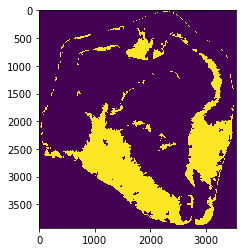

In [25]:
plt.imshow(mask,interpolation='None')
plt.show()

In [26]:
masked_img = np.ma.masked_where(np.dstack(3*[np.bitwise_not(mask)]), img)

In [27]:
mask3 = np.stack((mask,)*3, axis=-1)

In [28]:
marked_boundaries = mark_boundaries(img,segments,color=(1, 0.1, 0.1))

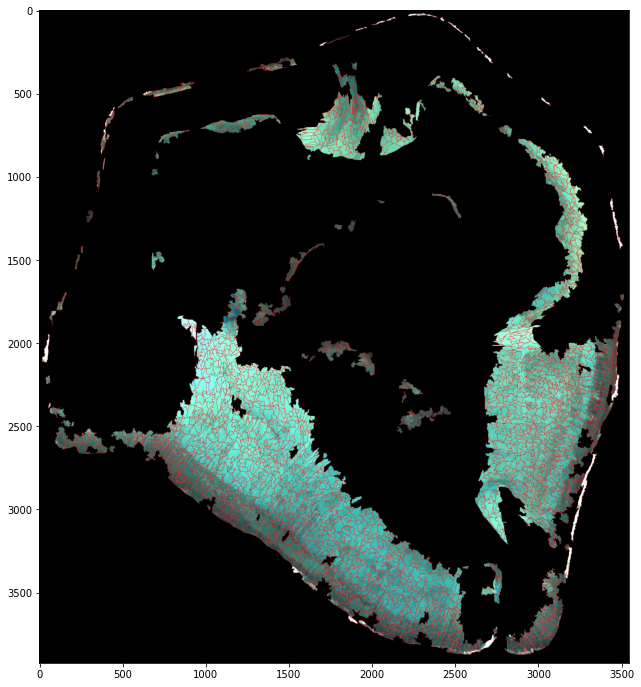

In [29]:
plt.figure(figsize=(12,12))
plt.imshow(marked_boundaries*mask3)
plt.show()

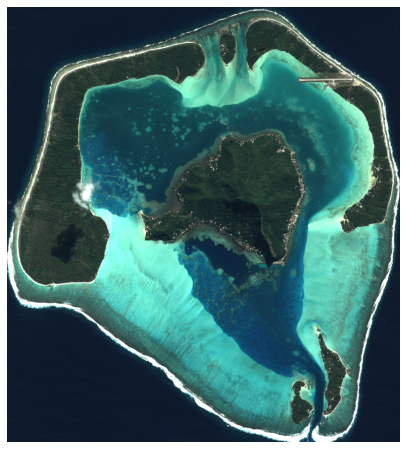

In [157]:
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(img)
plt.savefig('maupiti_pic_pleiades.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

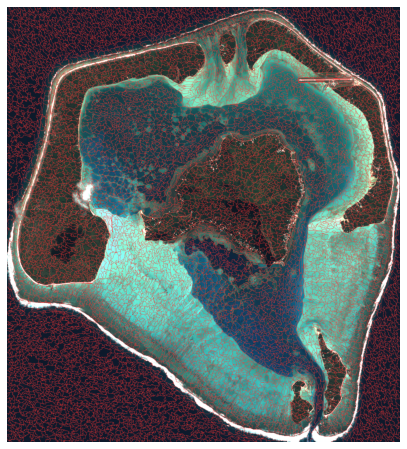

In [155]:
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(mark_boundaries(img,segments,color=(1,.2,.2)))
plt.savefig('full_img_segments.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [36]:
rugo_normalized=np.zeros(np.shape(rugo))
i=0
for zone in np.unique(rugo):
    rugo_normalized[rugo==zone]=i
    i+=1
rugo_normalized=rugo_normalized.astype(int)

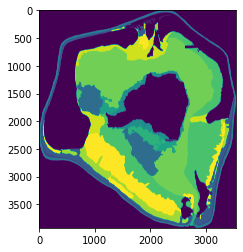

In [37]:
plt.imshow(rugo_normalized)
plt.show()

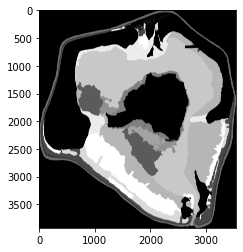

In [42]:
plt.imshow(np.dstack((rugo_normalized/14,rugo_normalized/14,rugo_normalized/14)))

In [105]:
plt.imshow(rugo_normalized,interpolation='None')
plt.axis('off')  
plt.gca().set_axis_off()
plt.savefig('temp_rugo_normalized.png', dpi=1299.25, bbox_inches='tight', pad_inches=0, origin='upper')
plt.close()

<ipython-input-105-4925330b8d26>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "origin" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('temp_rugo_normalized.png', dpi=1299.25, bbox_inches='tight', pad_inches=0, origin='upper')


In [106]:
rgb_rugo = Image.open('temp_rugo_normalized.png')

In [107]:
np.shape(rgb_rugo)

(3923, 3544, 4)

In [77]:
np.shape(rugo_normalized)

(3923, 3544)

In [115]:
marked_img = mark_boundaries(np.array(rgb_rugo)[:,:,:3],segments,color=(1,.2,.2))

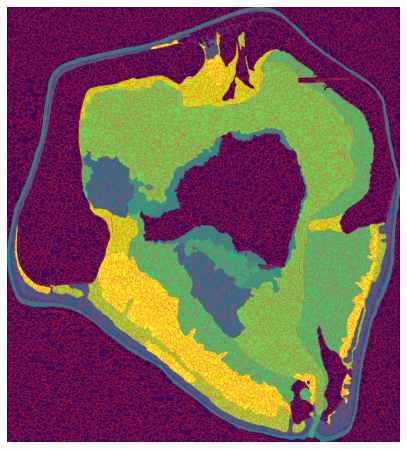

In [154]:
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(marked_img)
plt.savefig('full_img_zones_segments.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

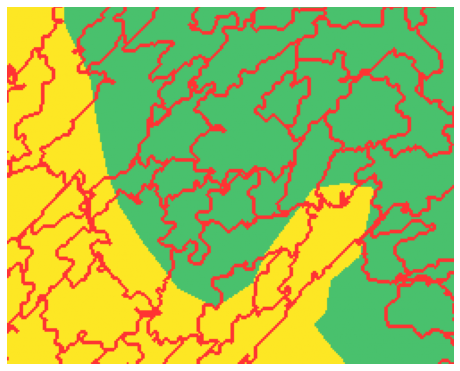

In [153]:
plt.figure(figsize=(8,8))
plt.axis('off') 
plt.imshow(marked_img[2800:3000,1500:1750])
plt.savefig('zoomed_img.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

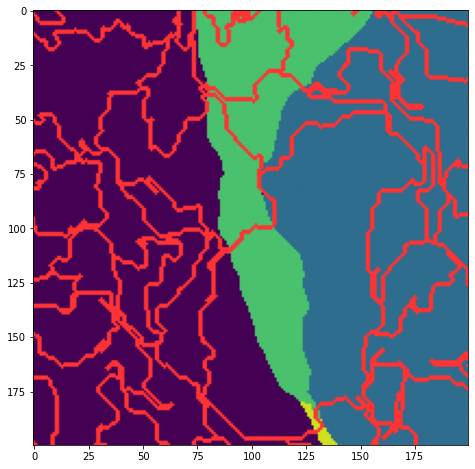

In [145]:
plt.figure(figsize=(8,8))
plt.imshow(marked_img[1550:1750,600:800])
plt.show()

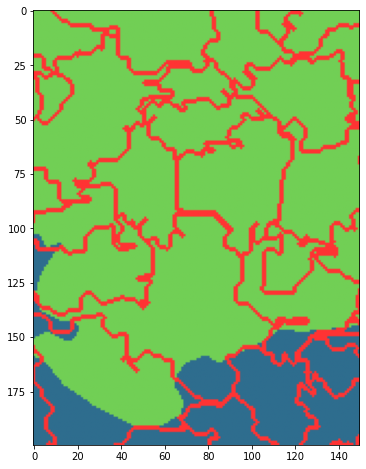

In [135]:
plt.figure(figsize=(8,8))
plt.imshow(marked_img[1200:1400,750:900])
plt.show()